# How does HTK compute features?

This notebook demonstrates the MFCC_HTK class and explains how the features are computed in detail.

## Algorithm breakdown

  1. split the window in frames and perform the following steps on each frame
  2. perform pre-emphasis of the signal frame
  3. multiply the frame by a Hamming window
  4. perform FFT to get the spectrum of the signal - use only half of the FFT for further computation
  5. apply triangular filters to compress the spectrum into a set of filter-banks
  6. take log of filterbank
  7. apply DCT to the filterbank to get RAW MFCCs
  8. normalize the MFCCs
  9. apply liftering
  10. optionally compute energy (either from signal or from spectrum)
  12. compute deltas and acceleration coefficients
  
## Importing the neccesary classes

First we will import the neccessary classes and libraries.

In [1]:
import sys
sys.path.append('../python')

from HTKFeat import MFCC_HTK
from HTK import HCopy, HTKFile

import numpy as np
%matplotlib inline
import matplotlib.pyplot as P

## Loading a sample audio

In the test folder, we have a sample audio file taken from the VoxForge project: http://www.voxforge.org/

We can load it using the simple method *load_raw_signal* included in the class MFCC_HTK.

We will also plot the oscilogram and the spectrogram of the audio below.

(0, 6)

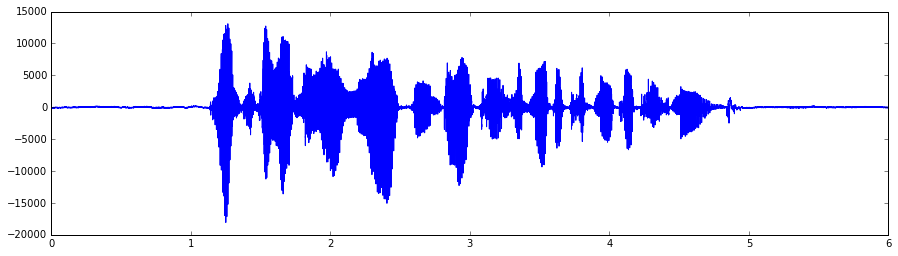

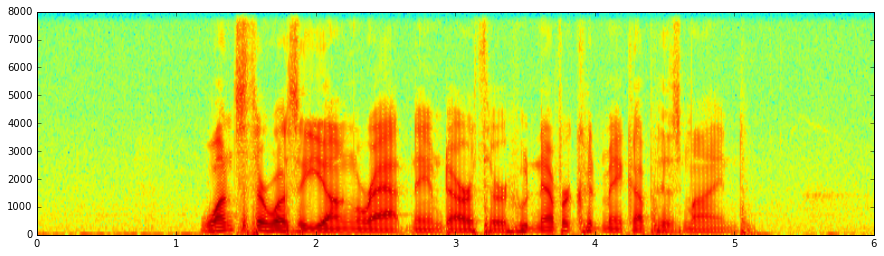

In [2]:
mfcc=MFCC_HTK()

signal = mfcc.load_raw_signal('../python-test/file.raw')

sig_len=signal.size/16000 #in seconds

P.figure(figsize=(15,4))
t=np.linspace(0,sig_len,signal.size)
P.plot(t,signal)
P.figure(figsize=(15,4))
s=P.specgram(signal,Fs=16000)
P.xlim(0,sig_len)

## DC removal

There are several things that can be done to an audio signal before it is analyzed by the system. One such thing is to make sure that all the data is cenetered around zero. This can easily be done by subtracting the mean of the signal, thus making the new mean zero. Often (as is the case here) a properly recorded signal will already have this property, but if it doesn't, it can mess up some of the computation below. This includes errors in computing energy and spectrogram. This artefact, known as the DC-offset, will be entirely stored in the 0'th frequency point of the FFT. Usually it will be ignored by the later steps, but it may cause issues if you forget about it. This library doesn't implement DC offset removal automatically (HTK does), but it's a trivial enough task to do yourself, if you need to:

In [3]:
print "Before: "+str(np.mean(signal))

signal = signal - np.mean(signal)

print "After: "+str(np.mean(signal))

Before: -1.07105
After: 2.73394107353e-14


## Splitting the signal into frames

This operation takes two parameters **win_len** and **win_shift**. The shift will determine how many windows we will get from the audio. If the shift is every 10ms, there are going to be 100 frames per second - this is the most common setting for anaylzing speech.

The length is also an important parameter. While you could set the length to be equal to the shift, by making it longer you can actually overlap the frames a little bit to better model the transitions between them and avoid loosing any information on the edges of frames (as discussed in windowing below). Many researchers will use "half-overlap" (meaning that frame length is double of frame shift), but there are other aspects worth noting about this parameter. The length of the window will first and foremost determine the amount of data we use for analysis. If the window is too short, some frequency components (especially the low ones) will not be modelled correctly - a very low frequency component would get split into several windows and wouldn't be represented accurately by any one of them. For speech we generally don't need to model anything lower than a couple of dozen Hz, so a window length of 25 ms is completely sufficient.

To compute the number of frames given the length of the signal, we need to account for the cases where not all frames can be full populated by the signal. If the last few frames cannot be fully populatd by the signal, we can either fill the rest of them with zeros (or other data) or we can discard them. In the case of this library, we discard them.

In [4]:
#these are a part of the configuration:
win_shift=160 
win_len=400

#the values above are in samples
#so 10ms * 16000 samples per second and 25ms * 16000 samples per second respectively

sig_len=len(signal)

#this is how we compute the window number while discarding the ones that don't fit the signal completely
win_num=np.floor((sig_len-win_len)/win_shift).astype('int')+1

wins=[]
for w in range(win_num):
    
    #these are the start and end of each window
    s=w*win_shift
    e=s+win_len
    
    #we need the copy of the data, because the numpy array slicing gives us a view of the data
    #and we don't won't to mess up the original signal when we start modifying the windows
    win=signal[s:e].copy()
    
    wins.append(win)
    
wins=np.asarray(wins)

## Pre-emphasis

Pre-emphasis is given by the formula:

\begin{equation}
\hat{s}_t=s_t-k\cdot s_{t-1}
\end{equation}

where $k$ is the pre-emphasis coefficient in the range $<0,1>$ given in the configuration. This operation is used to improve the SNR of the high frequency content of the signal, which is usually recorded at a lower quality. If we look at the process as a very simple FIR filter, its amplitude reponse would look something like this:

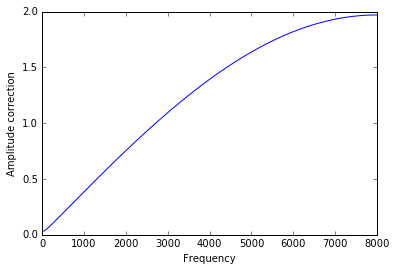

In [5]:
k=0.97
h = [1,-k]

f=np.linspace(0,8000,257)
P.plot(f,np.abs(np.fft.rfft(h,n=512)))
P.xlabel('Frequency')
P.ylabel('Amplitude correction')

In python we perform the pre-emphasis very easily, but we need to copy the first sample twice to match HTK's implementation for handling index -1 at the start of the operation:

In [6]:
for win in wins:
    win-=np.hstack((win[0],win[:-1]))*k    

## Windowing

Windowing is a very important step in the Fourier anaylsis of the signal. Since we are extracting a very short term window from a long signal, this is equivalent of multiplying the signal with a rectangular window of the length **win_len** positioned at a specific location. From signal processing theory, we know that multiplying two signals in the time domain is the same as performing convolution in the frequency domain. That is why we would like the function we use to extract the window in the spectrum domain to be as close to a dirac delta function as possible. While in practice this is imposible to achieve perfectly (apart from using a sync function, which has infinite length and therefore unusable in this case), there are many functions that try to approximate this as close as possbile. You can find an extensive list of such functions here:

http://mathworld.wolfram.com/ApodizationFunction.html

Below you will see the rectangular function and its frequency response and the Hamming function, as used in HTK. Note the values (in logarithm scale) for the frequency resposne of both functions.

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log


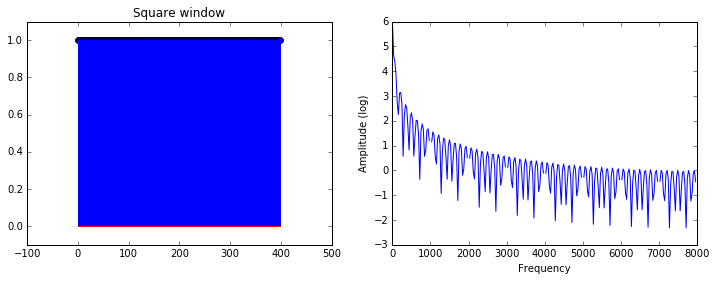

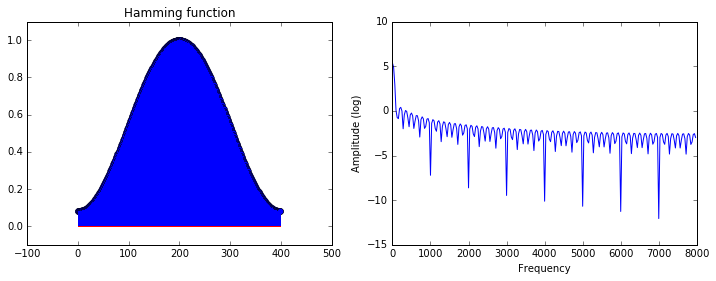

In [7]:
rect = np.ones(400)

P.figure(figsize=(12,4))
P.subplot(1,2,1)
P.stem(rect)
P.xlim(-100,500)
P.ylim(-0.1,1.1)
P.title('Square window')

f=np.linspace(0,8000,257)
P.subplot(1,2,2)
P.plot(f,np.log(np.abs(np.fft.rfft(rect,n=512))))
P.xlabel('Frequency')
P.ylabel('Amplitude (log)')

hamm = np.hamming(400)

P.figure(figsize=(12,4))
P.subplot(1,2,1)
P.stem(hamm)
P.xlim(-100,500)
P.ylim(-0.1,1.1)
P.title('Hamming function')

f=np.linspace(0,8000,257)
P.subplot(1,2,2)
P.plot(f,np.log(np.abs(np.fft.rfft(hamm,n=512))))
P.xlabel('Frequency')
P.ylabel('Amplitude (log)')

We apply the windowing function to all the frames here:

In [8]:
for win in wins:
    win*=hamm

# FFT

The Fourier Transform is used to compute the spectral content of the signal. FFT is usually computed to a power of two. Although not strictly neccessary for every implementation of this function, the algorithm is optimal if computed on vectors of length being a power of two. To get this value, we take the length of the window and find the smallest value greater than the window length and also a power of two. For window length of 400, this value is 512.

Numpy's FFT implemntation includes a bunch of functions prefixed 'r' that compute only half of the transform, since the result is symmetrical and we are only interested in the first half. The *rfft* method returns one value extra, so we discard that. Finally, we compute the absolute value to get the amplitude of the frequency response and discard the phase altogether.

(0, 256)

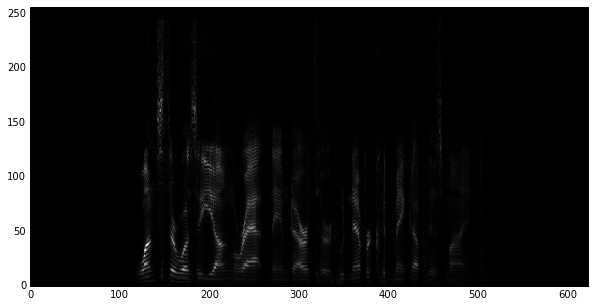

In [9]:
fft_len=np.asscalar(2**(np.floor(np.log2(win_len))+1).astype('int'))

ffts=[]
for win in wins:
    win=np.abs(np.fft.rfft(win,n=fft_len)[:-1])
    ffts.append(win)

ffts=np.asarray(ffts)

P.figure(figsize=(10,5))
P.pcolormesh(ffts.T,cmap='gray')
P.xlim(0,win_num)
P.ylim(0,fft_len/2)

## Filtering

The spectrum has quite a lot of points and we want a fairly small number of values to represent the signal at each point. That is why we reduce the number of points from 256, down to 26. Now we could do this by averaging the neighborhood values evenly thought the frequency range, but research has shown that human hearing is more sensitive to certain frequencies than others. In fact, there are several empirically discovered scales that describe our frequency sensitivity pretty well.

One such scale is the Mel scale and it was devised by letting lots of people listen to tones and judging which tones sound as having an equal distance from one another. Using this dataset, a formula was devised that fit the data very well. There are some criticisms behind this method, but it is still widely used by many people.

\begin{equation}
m = 2595 \log_{10} \left(1 + \frac{f}{700}\right)
\end{equation}

Or in a different base:

\begin{equation}
m = 1127 \ln \left(1 + \frac{f}{700}\right)
\end{equation}

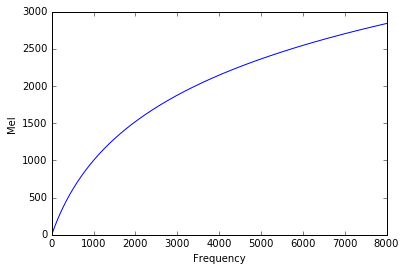

In [10]:
freq2mel = lambda freq: 1127*(np.log(1+((freq)/700.0)))

f = np.linspace(0,8000,1000)
m = freq2mel(f)

P.plot(f,m)
P.xlabel('Frequency')
P.ylabel('Mel')

Another similar concept is the Bark scale, which was used to determine the critical frequency bandwidths of hearing. One of the conculsion of that experiment was that there are 24 critical bands that play an important role in how humans percieve sound and that is why such a number is used for modeling speech. This is not to say, that humans perceive only 24 different frequencies - it is clear that we have a difficulty to perceive sounds whose pitch is very similar, but in real life the position of these bands is far from static. The model used in MFCC computation is much more simplified than reality.

Even though the number of critical frequencies is 24, many researchers decide to use 26 filterbanks instead. It is not entirely clear why (probably empirical reasons), but even HTKBook mentions 26 filters in their tutorial section. That is also a reason why many researchers copy this setup when writing their papers. For consistency, we will stick with 26. Again, the difference is probably insignificant anyway.

As far as the filters themselves, HTK uses a very crude model to generate the filterbanks. Filterbanks can generally be computed in one of two ways - by desiging their coefficients in the time domain (which can be difficult), or by averaging the spectrum (which is what is used in HTK). Since the amplitude spectrum itself can be interpreted as a very fine-grained filterbank averaging the points that correspond to the frequencies in the band of the filter can produce a very close approximation.

HTK goes one step further and uses triangular filters that are half-overalpping. To compute these filters, we need to detrmine the center frequencies of each of them (in the mel-scale) and set their bandwidths to correspond to the center frequencies of their neighbors. See below:

(0, 256)

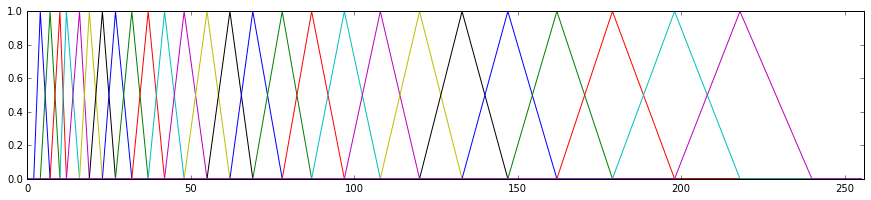

In [11]:
#this method creates the filters for our class
#normally it is run from the constructor
mfcc.create_filter(26)

P.figure(figsize=(15,3))
for f in mfcc.filter_mat.T:
    P.plot(f)
P.xlim(0,256)


Also worth noting is that the start and the end of the filterbank is determined by the **lo_freq** and **hi_freq** parameters of the system.

Now here is where things get a bit strange. It is not too difficult to design the filters that match the image above and this is exactly what is displayed in the HTK Book chapter on the filterbank, however the actual implementation differs
slightly.

As the author of the Python library, I am not too certain of why that is (is it a bug or a feature), so I have generated a set of 26 filters from HTK's C code and saved them in a CSV file. The C program (called gen_filt.c) is also included in the repo. If you want to have absolutely identical features as HTK, you should use that file. Otherwise, the differences are so small that it doesn't make much difference. This is what the HTK filters actually look like:

(0, 256)

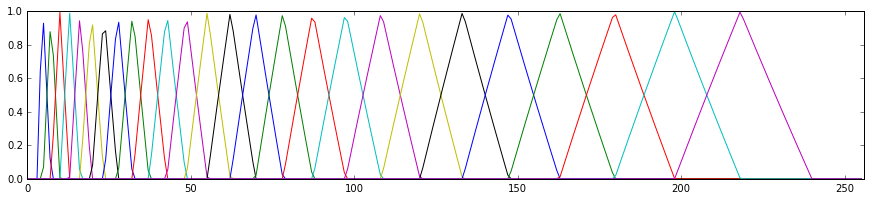

In [12]:
mfcc.load_filter('../python-test/filter.csv')

P.figure(figsize=(15,3))
for f in mfcc.filter_mat.T:
    P.plot(f)
P.xlim(0,256)

Once we have created a matrix with all the filters, it is enough to multiply the spectrum (calculated using FFT) with this matrix in order to get the output of the filters:

(0, 26)

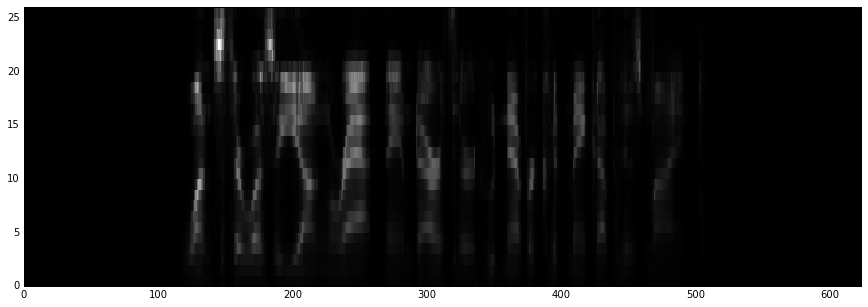

In [13]:
melspec=[]
for f in ffts:
    m = np.dot(f,mfcc.filter_mat)
    melspec.append(m)
melspec=np.asarray(melspec)

P.figure(figsize=(15,5))
P.pcolormesh(melspec.T,cmap='gray')
P.xlim(0,win_num)
P.ylim(0,26)

Now this image is obviously very similar to the one above, but much less detailed. One problem with it is that it's mostly black - a lot of it has a very small value. A common method to amplify the details in data, while at the same time attenuating the highlights is to use a logarithm. In the image below, note that there is a lot of information that was hidden before. Each word is clearly visible now.

(0, 26)

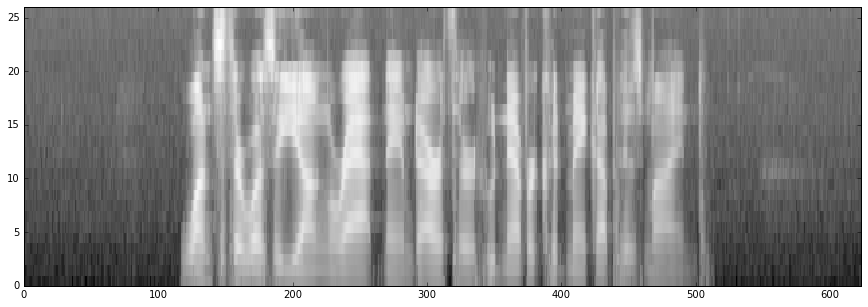

In [14]:
melspec = np.log(melspec)

P.figure(figsize=(15,5))
P.pcolormesh(melspec.T,cmap='gray')
P.xlim(0,win_num)
P.ylim(0,26)

## DCT

Once we computed the filterbanks we have a perfectly reasonable set of features to use in our speech recognition models or whatever else we may need, but we can still go a bit further. If we take another Fourier Transform of the data we have so far, we will have stepped from the spectrum domain and into the cepstrum domain (note the play of words).

Since again we are only interested in getting the amplitude of the Fourier Trasform and there is far less data to compute (only 26 input points) we can considerably simplify this procedure by using a Discrete Cosine Transfrom instead of the FFT. Using this formula, we can further compress our 26 spectral features into just 12 cepstral features. The formula for DCT is given like so:

\begin{equation}
X_k=\sum_{n=0}^{N-1} x_n \cdot \cos\left[\frac{\pi}{N} \left(n+\frac{1}{2}\right) k\right] \text{   , for }k\in[0,N-1]
\end{equation}

The whole right part of the formula (begining with cosine) can be pre-computed and stored into a matrix:

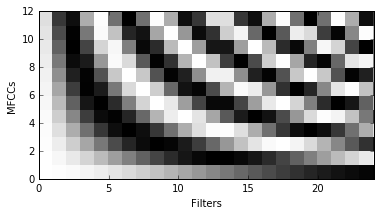

In [15]:
filter_num=26
mfcc_num=12

dct_base=np.zeros((filter_num,mfcc_num));
for m in range(mfcc_num):
    dct_base[:,m]=np.cos((m+1)*np.pi/filter_num*(np.arange(filter_num)+0.5))
    
P.figure(figsize=(6,3))
P.pcolormesh(dct_base.T,cmap='gray')
P.xlim(0,24)
P.ylim(0,12)
P.xlabel('Filters')
P.ylabel('MFCCs')

It may seem a bit harsh to use only half as many MFCCs as there are filterbanks, but it is generally understood that the higher coefficients bring far less useful information than the lower ones. After a certain point, we just stop seeing any benefits:

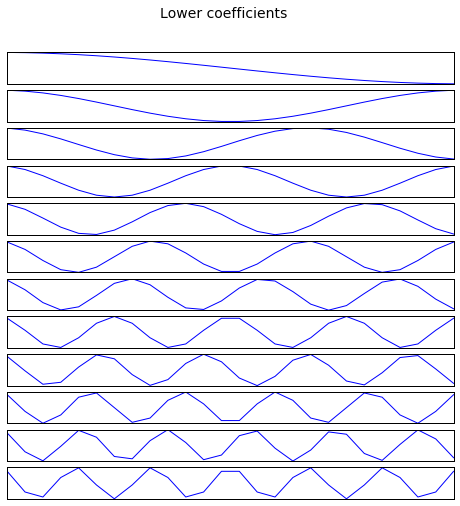

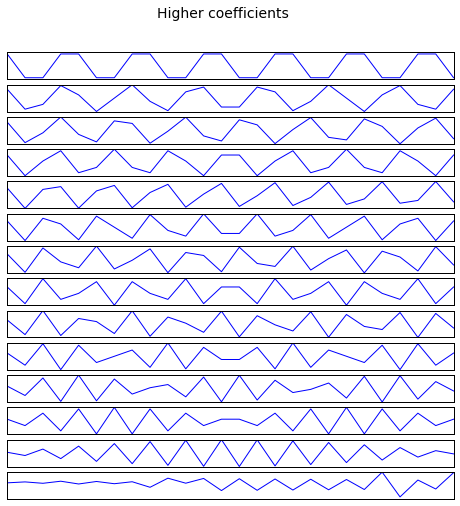

In [16]:
filter_num=26
mfcc_num=26

dct_base_f=np.zeros((filter_num,mfcc_num));
for m in range(mfcc_num):
    dct_base_f[:,m]=np.cos((m+1)*np.pi/filter_num*(np.arange(filter_num)+0.5))

f,ax=P.subplots(12,1,figsize=(8,8))
f.suptitle('Lower coefficients',fontsize=14)
for i in range(12):
    ax[i].plot(dct_base_f[:,i])
    ax[i].yaxis.set_visible(False)
    ax[i].xaxis.set_visible(False)
    
f,ax=P.subplots(14,1,figsize=(8,8))
f.suptitle('Higher coefficients',fontsize=14)
for i in range(12,26):
    ax[i-12].plot(dct_base_f[:,i])
    ax[i-12].yaxis.set_visible(False)
    ax[i-12].xaxis.set_visible(False)

All that remains now is to perform matrix multiplication of the mel spectrogram with the DCT matrix to receive the MFCCs:

(0, 12)

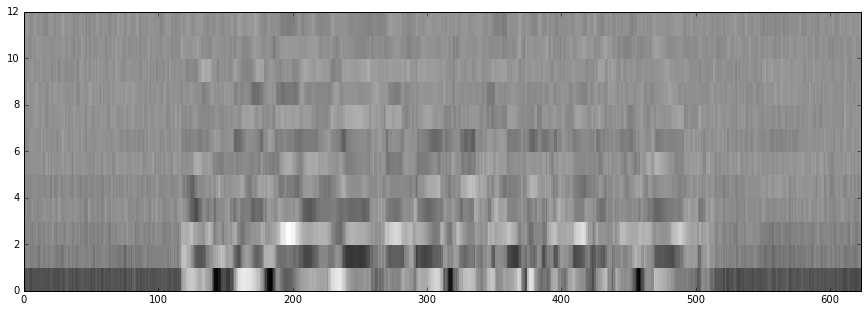

In [17]:
filter_num=26
mfcc_num=12

mfccs=[]
for m in melspec:
    c=np.dot(m,dct_base)
    mfccs.append(c)
mfccs=np.asarray(mfccs)

P.figure(figsize=(15,5))
P.pcolormesh(mfccs.T,cmap='gray')
P.xlim(0,win_num)
P.ylim(0,mfcc_num)

Please note that this diagram is far less readable than the spectrogram. Nevertheless, such computed features do perform better than simple mel spectrogram features in almost any model out there. There are several theories that explain this phenomenon.

One theory mentions that using the DCT is essentialy de-correlating the input data making them better for mdeling purposes. Another theory says that performing subtraction in the cepstral domain is equivalent to making a deconvolution of the signal and indeed the math would support this. 

If we imagine that all signals are recorded in a specific environemnt (by specific people, using specific microphones, in specific locations, etc) it would be useful to be able to take that aspect *out of the equation*, so to speak. We could do this by having an exact profile of the environment and performing a costly process of deconvolution, but there seems to be an easier way. If we treat cepstral subtraction as the equivalent of deconvolution, we can consider the mean of the cepstrum as the stationary aspect of all the frames of the audio in question and in essence the equivalent of the enviornment profile we want to remove. Cepstral Mean and Variance Normalization is often used as a tool to achieve this goal.

Knowing this, it should be noted that such features may not be best for each task we want to solve. If we want to recognize phonemes in a speaker-indepent manner, these features are excellent. If we want to differentiate speakers, however, it may not be a good idea to used normalized MFCCs. In fact, it may be a better idea to use the difference from the mean as a discerning factor, instead. I haven't tried this, however.

Before we continue, one more small step is performed by HTK: all the MFCCs are multiplied by a normalizing factor dependent on the number of filters. If your goal is to perform speech modeling on these features, this step probably doesn't do anything. I am still including it here for compatiliblity reasons.

In [18]:
mfnorm = np.sqrt(2.0 / filter_num)

mfccs*=mfnorm

## Lifter

Liftering is the same thing as filtering. We mentioned earlier that filtering can be done by performing multiplication in the spectrum domain. Well liftering is simply multiplication in the cepstral domain (note spectrum -> cepstrum and filter -> lifter).

The shape of the lifter used in HTK amplifies some of the higher cepstral coefficients, which would normally have a lower amplitude. The lifter parameter determines the shape of this modification (try it out below).

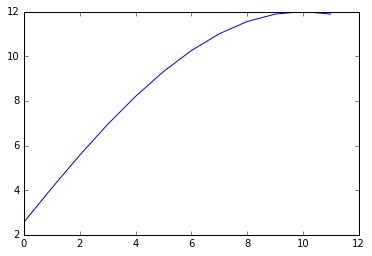

In [19]:
lifter_num=22

lifter=1+(lifter_num/2)*np.sin(np.pi*(1+np.arange(mfcc_num))/lifter_num)

P.plot(lifter)

Performing the acual operation is very easy and greatly improves the readibility of the higher coefficients (compared to the previous figure):

(0, 12)

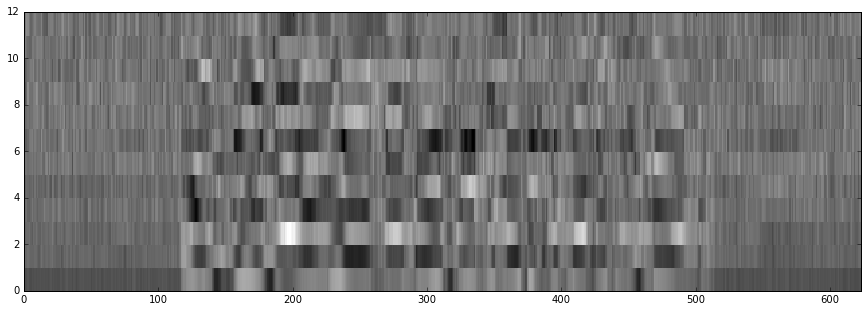

In [20]:
mfccs*=lifter

P.figure(figsize=(15,5))
P.pcolormesh(mfccs.T,cmap='gray')
P.xlim(0,win_num)
P.ylim(0,mfcc_num)

## Energy

Energy is normaly defined as the sum of the square of the signal samples and this is what is implemented in the **raw_enegry** feature:

\begin{equation}
E = \sum_{n} x_n^{2}
\end{equation}

Alternatively, one can use the 0'th cepstral coefficient instead of energy. Theoretically these two values should be the same (or at least very correlated). Now, we don't really compute the 0'th coefficient in the DCT equation, because there is a less costly procedure to achieve the same value. What we do is simply add all the filters in the filterbank together to get the joint energy of all the filters in the given frame.

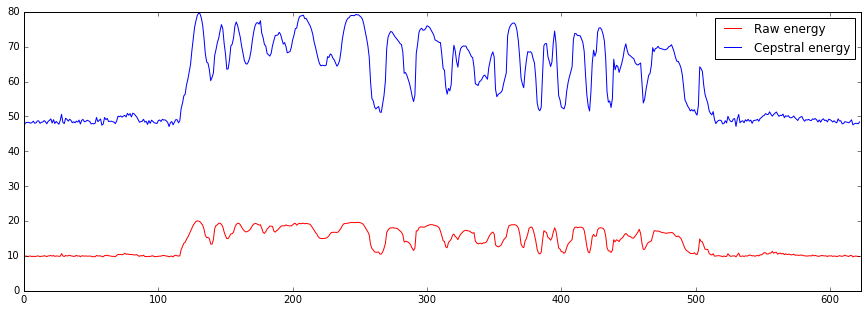

In [21]:
raw_energy=[]
for win in wins:
    raw_energy.append(np.log(np.sum(win**2)))
raw_energy=np.asarray(raw_energy)

ceps_energy=[]
for m in melspec:
    ceps_energy.append(np.sum(m)*mfnorm)
ceps_energy=np.asarray(ceps_energy)
    
P.figure(figsize=(15,5))
P.plot(raw_energy,'r',label='Raw energy')
P.plot(ceps_energy,'b',label='Cepstral energy')
P.xlim(0,win_num)
P.legend()

## Regression coefficients

Deltas allow modeling change in the consecutive frames. While a trivial observation, many models benefit greatly from having such feature present. HTK uses a more complex formula for computing the deltas:

\begin{equation}
d_t=\frac{\sum_{\theta=1}^{\Theta} \theta \cdot (c_{t+\theta}-c_{t-\theta})}{2\sum_{\theta=1}^{\Theta} \theta^2}
\end{equation}

Where $\Theta$ is a parameter of the program known as *DELTAWIN* and usually set to 2. This parameter lets us increase the context of the delta computation, while at the same time making sure that the values closer to the actual sample have a greater weight than the ones further away. The sum in the denominator is simply a normalizing factor to keep the value from becoming too large.

Regression coefficient of the first order is known as delta, while second order coefficients are known as acceleration coefficients. Acceleration coefficients are calculated simply by appliying the same delta formula on the deltas, computed before.

One question remains is what to do with the boundary values, where there are no samples, ie. what to do with $c_{-1}$ or $c_{-2}$ or $c_{T+1}$ where $T$ is the number of samples? There are many options, e.g. zero-padding (assuming zeros are everywhere outside the list), wraping (going to the begining of the list once we reach the end and vice versa), but HTK uses duplication as its strategy. Basically, the first and the last values are duplicated to infinity. This provides many benefits, especially when it comes to computing deltas (first deltas are gonna be low and predicatable) and is easier to implement than it seems.

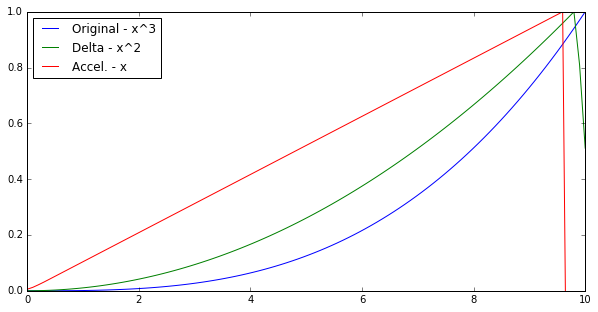

In [22]:
x=np.linspace(0,10,100)
y=x**3
y=y.reshape((y.size,1))

d=mfcc.get_delta(y,deltawin=2) #deltas
a=mfcc.get_delta(d,deltawin=2) #acceleration

#plots are normalized to <0,1> to fit on the same screen
P.figure(figsize=(10,5))
P.plot(x,y/np.max(y),label='Original - x^3')
P.plot(x,d/np.max(d),label='Delta - x^2')
P.plot(x,a/np.max(a),label='Accel. - x')
P.ylim(0,1)
P.legend(loc='upper left')